Install pre-required packages. 
Note that tensorflow version is set to 2.9.1 as there exists a bug inhibiting the saving of the EfficientNet weights within current versions.

In [1]:
!pip install pyyaml h5py
!pip install tensorflow==2.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Imports

In [2]:
from tensorflow.keras.applications.efficientnet import EfficientNetB6
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data import AUTOTUNE
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

import sys
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

**The below process and model structure draws inspiration from Keras documentation and examples, specifically the following source:** https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

Create Link to Google Drive where image dataset is stored

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Create file paths to Datasets on Google Drive

In [6]:
data = pathlib.Path('/content/gdrive/MyDrive/wildlife_presence')
test = pathlib.Path('/content/gdrive/MyDrive/test')
save_path = pathlib.Path('/content/gdrive/MyDrive/saved_models/')
top_checkpoint_path = pathlib.Path('/content/gdrive/MyDrive/top_layer_training/cp.ckpt')
std_checkpoint_path = pathlib.Path('/content/gdrive/MyDrive?std_training/cp.ckpt')

Define the strategy to be used. Either TPU, or GPU strategy

In [7]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy


# Model


Specify model basics

In [8]:
img_path = data
test_path = test
img_size = 528
batch_size=32
classes = 2

Specify transfer learning build of Efficient Net.
**Note:** This is model build 1. 

In [9]:
# Modified Network allowing for transfer learning
def build_efficientnet_01():
    inputs = layers.Input(shape=(img_size, img_size, 3))  # Construct the expected image input
    model = EfficientNetB6(include_top=False,
                           input_tensor=inputs,
                           weights='imagenet')  # Initialize efficientnet model with imagenet weights
    model.trainable = False  # Freeze the pre-trained weights

    # Rebuild the top layers
    x = Sequential()
    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(2048, activation='relu')(x)
    predictions = Dense(classes, activation='softmax')(x)

    # Initialize model
    model = Model(inputs=model.input, outputs=predictions, name='EfficientNet')
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


This is model build 2

In [10]:
# Modified Network allowing for transfer learning
def build_efficientnet_02():
    inputs = layers.Input(shape=(img_size, img_size, 3))  # Construct the expected image input
    model = EfficientNetB6(include_top=False,
                           input_tensor=inputs,
                           weights='imagenet')  # Initialize efficientnet model with imagenet weights
    model.trainable = False  # Freeze the pre-trained weights

    # Rebuild the top layers
    x = Sequential()
    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)

    top_dropout_rate=0.2
    x = Dropout(top_dropout_rate, name='top_dropout')(x)
    predictions = Dense(classes, activation='softmax')(x)

    # Initialize model
    model = Model(inputs=model.input, outputs=predictions, name='EfficientNet')
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

Method to generate train and evaluation image datasets

In [11]:
def import_dataset(file_path: str):

    train_ds = image_dataset_from_directory(directory=file_path,
                                            validation_split=0.2,
                                            subset='training',
                                            seed=123,
                                            image_size=(img_size, img_size),
                                            batch_size=batch_size,
                                            labels='inferred',
                                            label_mode='categorical')
    val_ds = image_dataset_from_directory(directory=file_path,
                                          validation_split=0.2,
                                          subset='validation',
                                          seed=123,
                                          image_size=(img_size, img_size),
                                          batch_size=batch_size,
                                          labels='inferred',
                                          label_mode='categorical')

    print(train_ds.class_names)
    return train_ds, val_ds

Method to generate seperate test image dataset for additional validation of the models

In [12]:
def generate_test_set(file_path: str):
  test_ds = image_dataset_from_directory(directory=file_path,
                                         seed=123,
                                         image_size=(img_size, img_size),
                                         labels='inferred',
                                         label_mode='categorical')
  print(test_ds.class_names)
  return test_ds

Method to perform the training of the top-weights, or rather the additional layers added on top of the already trained Efficient Net, focusing specifically ont raining these layers, by freezing the existing EfficientNet layers.

In [22]:
def train_top_weights(train_ds, eval_ds, model_type:int = 1):
  with strategy.scope():
    if model_type == 1:
      model = build_efficientnet_01()
    if model_type == 2:
      model = build_efficientnet_02()

  # Create dataset weighting
  classes = train_ds.class_names
  print(classes)
  weight_values = compute_class_weight(class_weight='balanced', 
                                       classes=classes, 
                                       y=get_image_labels(train_ds))
  print(weight_values)
  weights = dict(zip([0, 1], weight_values))

  train_ds = train_ds.prefetch(AUTOTUNE) 

  epochs = 10
  hist = model.fit(train_ds, 
                   epochs=epochs, 
                   validation_data=eval_ds, 
                   verbose=2,
                   class_weight=weights)
  return model, hist

Method to create a plot of the training and validation accuracies over training epochs

In [14]:
def plot_hist(hist, title):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history['val_accuracy'])
    plt.title(title)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"])
    plt.show

Methods to aid is creating labelled predictions and class weighting. 

In [15]:
label_dict = {1: 'Present', 0: 'Absent'}

In [16]:
def ohe_to_label(preds):
  y_pred = np.argmax(preds, axis=1)
  predicted_labels = []
  for pred in y_pred:
    predicted_labels.append(label_dict[pred]) 
  return predicted_labels

def get_image_labels(ds):
  ohe_labels = []
  labels = []
  for x,y in ds:
    ohe_labels.extend(np.argmax(y.numpy().tolist(), axis=1))
  for label in ohe_labels:
      labels.append(label_dict[label])
  return labels

Method to unfreeze entire mode (Except BatchNormalization layers) and allow for entire model training.

In [17]:
def unfreeze_model(model):
  for layer in model.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
      layer.trainable = True
  
  optimizer = Adam(learning_rate=1e-5)
  model.compile(optimizer=optimizer, 
                loss='binary_crossentropy',
                metrics='accuracy')
  return model

In [18]:
def train_unfrozen_model(model, train_ds, eval_ds):
  epochs = 10

  # Create dataset weighting
  classes = train_ds.class_names
  weight_values = compute_class_weight(class_weight='balanced', 
                                       classes=classes, 
                                       y=get_image_labels(train_ds))
  weights = dict(zip([0, 1], weight_values))

  hist = model.fit(train_ds, 
                   epochs=epochs, 
                   validation_data=eval_ds, 
                   verbose=2,
                   class_weight=weights)
  return model, hist

## Model Training

#### Model 01

In [74]:
save_path = pathlib.Path('/content/gdrive/MyDrive/saved_models/model_1')

In [23]:
# Generate dataset and pre-tune
train_ds, eval_ds = import_dataset(img_path)
test_ds = generate_test_set(test)
print(eval_ds)

# Train model top layers
model, hist = train_top_weights(train_ds, eval_ds, 1)

Found 787 files belonging to 2 classes.
Using 630 files for training.
Found 787 files belonging to 2 classes.
Using 157 files for validation.
['Absent', 'Present']
Found 170 files belonging to 2 classes.
['Absent', 'Present']
<BatchDataset element_spec=(TensorSpec(shape=(None, 528, 528, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
['Absent', 'Present']


InvalidArgumentError: ignored

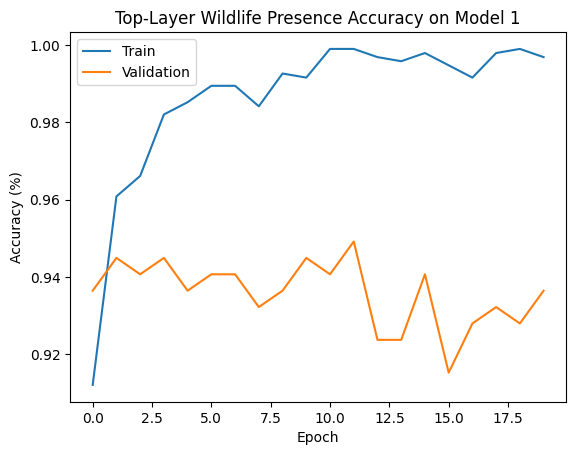

In [20]:
plot_hist(hist, "Top-Layer Wildlife Presence Accuracy on Model 1")

In [21]:
# Unfreeze model 
model = unfreeze_model(model)

# Train model in its entirety
model, hist = train_unfrozen_model(model, train_ds, eval_ds)

Epoch 1/10
30/30 - 93s - loss: 0.0080 - accuracy: 0.9947 - val_loss: 0.4771 - val_accuracy: 0.9322 - 93s/epoch - 3s/step
Epoch 2/10
30/30 - 64s - loss: 0.0073 - accuracy: 0.9979 - val_loss: 0.5459 - val_accuracy: 0.9407 - 64s/epoch - 2s/step
Epoch 3/10
30/30 - 63s - loss: 0.0061 - accuracy: 0.9979 - val_loss: 0.5616 - val_accuracy: 0.9364 - 63s/epoch - 2s/step
Epoch 4/10
30/30 - 62s - loss: 0.0037 - accuracy: 0.9989 - val_loss: 0.5545 - val_accuracy: 0.9195 - 62s/epoch - 2s/step
Epoch 5/10
30/30 - 63s - loss: 0.0016 - accuracy: 0.9989 - val_loss: 0.5167 - val_accuracy: 0.9237 - 63s/epoch - 2s/step
Epoch 6/10
30/30 - 63s - loss: 6.2124e-04 - accuracy: 1.0000 - val_loss: 0.5086 - val_accuracy: 0.9195 - 63s/epoch - 2s/step
Epoch 7/10
30/30 - 63s - loss: 0.0012 - accuracy: 0.9989 - val_loss: 0.5130 - val_accuracy: 0.9195 - 63s/epoch - 2s/step
Epoch 8/10
30/30 - 63s - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.5196 - val_accuracy: 0.9280 - 63s/epoch - 2s/step
Epoch 9/10
30/30 - 63s - los

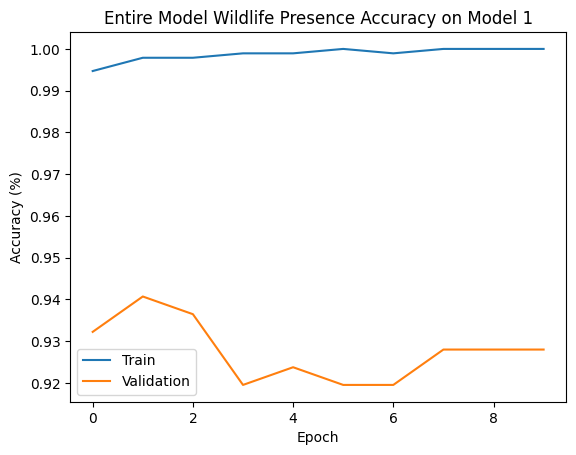

In [22]:
plot_hist(hist, "Entire Model Wildlife Presence Accuracy on Model 1")

In [23]:
preds = model.predict(test_ds)

6/6 [==============================] - 46s 2s/step


In [24]:
predicted_labels = ohe_to_label(preds)
true_labels = get_image_labels(test_ds)

In [25]:
cm = confusion_matrix(true_labels, predicted_labels)

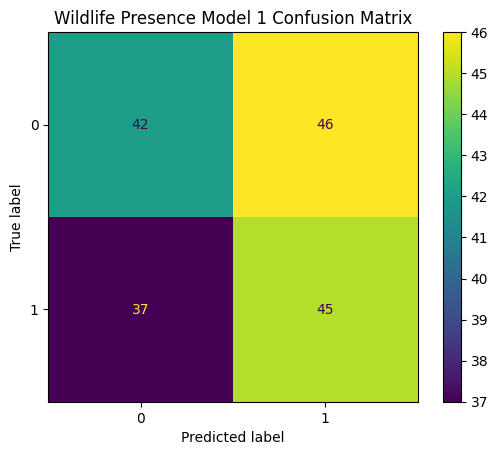

In [26]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.title('Wildlife Presence Model 1 Confusion Matrix')
plt.show()

In [27]:
report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

      Absent       0.53      0.48      0.50        88
     Present       0.49      0.55      0.52        82

    accuracy                           0.51       170
   macro avg       0.51      0.51      0.51       170
weighted avg       0.51      0.51      0.51       170



In [28]:
model.save(save_path)

#### Model 02

In [29]:
save_path = pathlib.Path('/content/gdrive/MyDrive/saved_models/model_2')
model = keras.models.load_model(save_path)

Train model if it has not been saved previously

In [30]:
# Generate dataset and pre-tune
train_ds, eval_ds = import_dataset(img_path)
test_ds = generate_test_set(test)


# Train model top layers
model, hist = train_top_weights(train_ds, eval_ds, 2)

Found 1180 files belonging to 2 classes.
Using 944 files for training.
Found 1180 files belonging to 2 classes.
Using 236 files for validation.
['Absent', 'Present']
Found 170 files belonging to 2 classes.
['Absent', 'Present']
Epoch 1/20
30/30 - 88s - loss: 0.3840 - accuracy: 0.8538 - val_loss: 0.3803 - val_accuracy: 0.9407 - 88s/epoch - 3s/step
Epoch 2/20
30/30 - 63s - loss: 0.1887 - accuracy: 0.9407 - val_loss: 0.3096 - val_accuracy: 0.9322 - 63s/epoch - 2s/step
Epoch 3/20
30/30 - 62s - loss: 0.1832 - accuracy: 0.9407 - val_loss: 0.2858 - val_accuracy: 0.9280 - 62s/epoch - 2s/step
Epoch 4/20
30/30 - 60s - loss: 0.1601 - accuracy: 0.9492 - val_loss: 0.2614 - val_accuracy: 0.9407 - 60s/epoch - 2s/step
Epoch 5/20
30/30 - 60s - loss: 0.1467 - accuracy: 0.9544 - val_loss: 0.2430 - val_accuracy: 0.9364 - 60s/epoch - 2s/step
Epoch 6/20
30/30 - 60s - loss: 0.1670 - accuracy: 0.9449 - val_loss: 0.2156 - val_accuracy: 0.9364 - 60s/epoch - 2s/step
Epoch 7/20
30/30 - 62s - loss: 0.1193 - accura

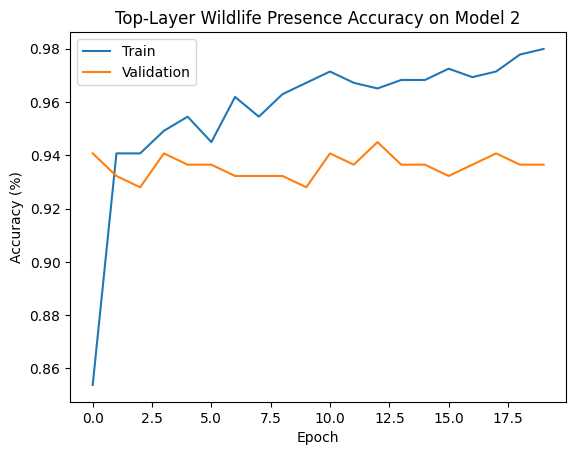

In [31]:
plot_hist(hist, "Top-Layer Wildlife Presence Accuracy on Model 2")

In [32]:
# Unfreeze model 
model = unfreeze_model(model)

# Train model in its entirety
model, hist = train_unfrozen_model(model, train_ds, eval_ds)

Epoch 1/10
30/30 - 88s - loss: 0.0886 - accuracy: 0.9703 - val_loss: 0.2270 - val_accuracy: 0.9407 - 88s/epoch - 3s/step
Epoch 2/10
30/30 - 65s - loss: 0.0592 - accuracy: 0.9799 - val_loss: 0.2314 - val_accuracy: 0.9407 - 65s/epoch - 2s/step
Epoch 3/10
30/30 - 64s - loss: 0.0652 - accuracy: 0.9809 - val_loss: 0.2340 - val_accuracy: 0.9407 - 64s/epoch - 2s/step
Epoch 4/10
30/30 - 64s - loss: 0.0378 - accuracy: 0.9852 - val_loss: 0.2693 - val_accuracy: 0.9407 - 64s/epoch - 2s/step
Epoch 5/10
30/30 - 64s - loss: 0.0443 - accuracy: 0.9841 - val_loss: 0.2822 - val_accuracy: 0.9407 - 64s/epoch - 2s/step
Epoch 6/10
30/30 - 63s - loss: 0.0380 - accuracy: 0.9894 - val_loss: 0.2673 - val_accuracy: 0.9449 - 63s/epoch - 2s/step
Epoch 7/10
30/30 - 63s - loss: 0.0339 - accuracy: 0.9915 - val_loss: 0.2962 - val_accuracy: 0.9364 - 63s/epoch - 2s/step
Epoch 8/10
30/30 - 63s - loss: 0.0267 - accuracy: 0.9947 - val_loss: 0.3055 - val_accuracy: 0.9407 - 63s/epoch - 2s/step
Epoch 9/10
30/30 - 63s - loss: 0

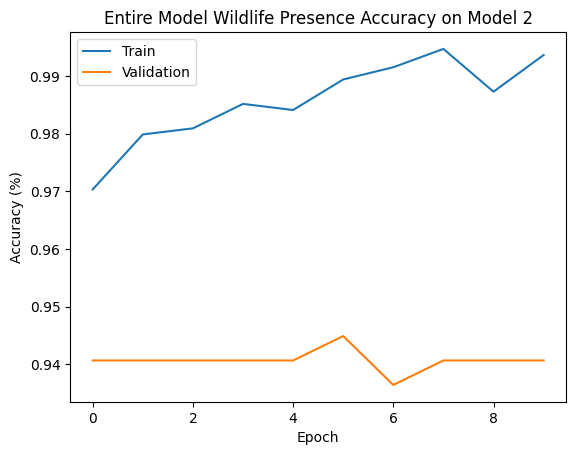

In [33]:
plot_hist(hist, "Entire Model Wildlife Presence Accuracy on Model 2")

In [34]:
preds = model.predict(test_ds)

6/6 [==============================] - 14s 1s/step


In [35]:
predicted_labels = ohe_to_label(preds)
true_labels = get_image_labels(test_ds)

In [36]:
cm = confusion_matrix(true_labels, predicted_labels)

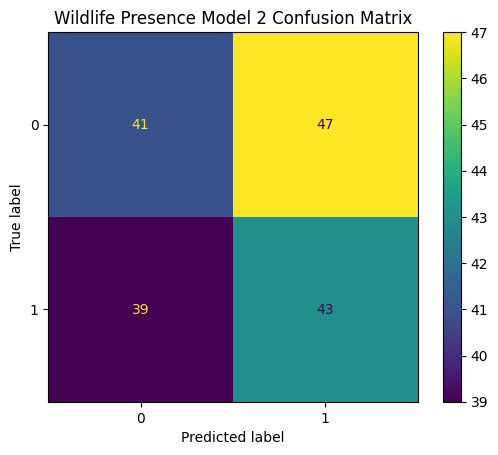

In [37]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.title('Wildlife Presence Model 2 Confusion Matrix')
plt.show()

In [38]:
report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

      Absent       0.51      0.47      0.49        88
     Present       0.48      0.52      0.50        82

    accuracy                           0.49       170
   macro avg       0.50      0.50      0.49       170
weighted avg       0.50      0.49      0.49       170



In [39]:
model.save(save_path)